Scratchwork for robot simulation with forward dynamics

In [448]:
import numpy as np 
import modern_robotics as mr

In [449]:
def getT_list(th):
    # The link lengths are defined as L1 and L2, or L = [L1 L2]'
    L1 = 1
    L2 = 1

    # reshape theta to be (2,)
    th = np.reshape(th, (2,))

    # The home configuration of a 2R planar robot
    p = np.array([[L1+L2], [0], [0]]) # The end effector position in the home configuration
    M02 = np.block([[np.eye(3), p], [0, 0, 0, 1]]) # The end effector frame in the home configuration
    p = np.array([[L1], [0], [0]]) # The first joint position in the home configuration
    M01 = np.block([[np.eye(3), p], [0, 0, 0, 1]]) # The first joint frame in the home configuration
    p = np.array([[0], [0], [0]]) # The base frame in the home configuration
    M00 = np.block([[np.eye(3), p], [0, 0, 0, 1]]) # The base frame in the home configuration

    # Screw Axis
    # A screw axis is a line about which a rigid body move and rotate it is defined by a unit vector s and a point q that lies on the line 
    s1 = np.array([[0], [0], [1], [0], [0], [0]]) 
    s2 = np.array([[0], [0], [1], [0], [-L1], [0]])
    Slist = np.hstack((s1, s2))

    # Forward Kinematics
    T02 = mr.FKinSpace(M02, Slist, th)
    T01 = mr.FKinSpace(M01, s1, [th[0]])
    T00 = mr.FKinSpace(M00, s1, [th[0]])

    T_list = [T00,T01, T02]

    return T_list

In [450]:
def mcgeval(th,th_d):
    
    L1 = 1.0  # Length of link 1
    L2 = 1.0  # Length of link 2
    r1 = .75 # Distance from joint 1 to center of mass of link 1
    r2 = .75 # Distance from joint 2 to center of mass of link 2
    m1 = .1  # Mass of link 1
    m2 = .1  # Mass of link 2
    g = 9.8  # Gravity

    # Mass Matrix
    M = np.array([
        [m1*L1**2 + m2*(L1**2 + 2*L1*r2*np.cos(th[1,0]) + L2**2), m2*(L1*r2*np.cos(th[1,0]) + L2**2)],
        [m2*(L1*r2*np.cos(th[1,0]) + r2**2), m2*r2**2]
    ])

    # Coriolis Vector
    C = np.array([
        [-m2*L1*r2*np.sin(th[1,0])*(2*th_d[0,0]*th_d[1,0] + th_d[1,0]**2)],
        [m2*L1*r2*th_d[0,0]**2*np.sin(th[1,0])]
    ])

    # Gravity Vector
    G = np.array([
        [(m1 + m2)*L1*g*np.cos(th[0,0]) + m2*g*r2*np.cos(th[0,0] + th[1,0])],
        [m2*g*r2*np.cos(th[0,0] + th[1,0])]
    ])

    return M, C, G

def run(Jeval,th_init,th_d_init,T,lr=.01,n_iter=1000):

    th = th_init
    th_d = th_d_init

    # Create history dictionary 
    hist = {'th': [], 'th_d': [], 'th_dd': [], 'M': [], 'C': [], 'G': [], 'T': [], 'X': [] }

    # Loop over iterations
    for i in range(n_iter):

        integrations = 5
        for i in range(integrations):

            # Evaluate the equations of motion
            M, C, G = Jeval(th,th_d)

            # Solve for th_dd using the equations of motion
            th_dd = np.linalg.solve(M, T - C - G)

            # Update the joint parameters, Euler integration
            th_d = th_d + lr * th_dd
            th = th + lr * th_d

        # The end effector position 
        T_list = getT_list(th)
        Tend = T_list[2]
        X = Tend[0:3,3]

        # Save the history
        hist['th'].append(th)
        hist['th_d'].append(th_d)
        hist['th_dd'].append(th_dd)
        hist['M'].append(M)
        hist['C'].append(C)
        hist['G'].append(G)
        hist['T'].append(T)
        hist['X'].append(X)

    return hist


In [451]:
th = np.array([[0], [0]])  # joint angles
th_d = np.array([[0], [0]])  # joint velocities
T = np.array([[0],[0]]) # joint torques

hist = run(mcgeval,th,th_d,T,lr=.00015,n_iter=10000)

(10000, 3)


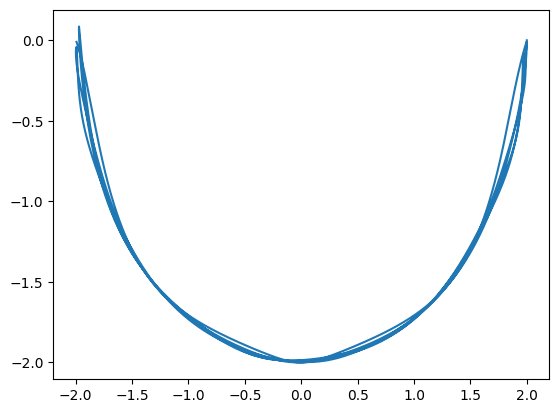

In [452]:
# plot X over time 
import matplotlib.pyplot as plt
X = np.array(hist['X'])
print(X.shape)

plt.plot(X[:,0],X[:,1])
plt.show()

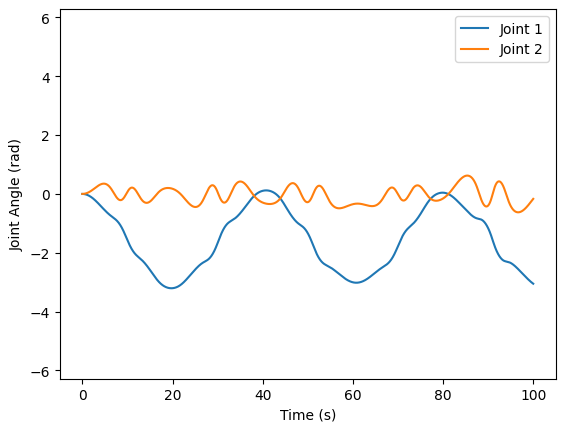

In [453]:
# plot the joint angles

total_time = len(hist['th'])*lr

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.arange(0,total_time,lr),[h[0,0] for h in hist['th']])
ax.plot(np.arange(0,total_time,lr),[h[1,0] for h in hist['th']])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Joint Angle (rad)')
ax.legend(['Joint 1','Joint 2'])

# set the axes limits to show -2 pi to 2 pi
ax.set_ylim(-2*np.pi,2*np.pi)
plt.show()
